# **2D Self supervision pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapy.readthedocs.io/en/latest/) pipeline for **2D self supervision** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_train_0.png' width='300px'/>
<img src='https://biapy.readthedocs.io/en/latest/_images/lucchi_train_0_crap.png' width='300px'/>
<figcaption><b>Figure 1</b>: Example of a 2D self supervision problem. From left to right: 2D electron microscopy image and its worstened version (for 'crappify' pretext task.</figcaption></center>
</figure>

**Without any coding**, we explain step by step how to
1. **upload a set of training and test images** without any label, as this is unsupervised,
2. **train a deep neural network (DNN)** model on the training set,
3. **apply the model** to the test images, and
4. **download the model's weigths** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired in the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook has been made by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). If you have any suggestion or comment, or find any problem, please write us an email or [create an issue in BiaPy's repository](https://github.com/danifranco/BiaPy/issues). Thanks!

## **Expected inputs and outputs**
___
**Inputs**

This notebook expects two folders as input:
* **Training raw images**: with the raw 2D images to train the model.
* **Output folder**: a path to store the workflow results.

**Outputs**

If the execution is successful, a folder will be created containing the workflow results.

<font color='red'><b>Note</b></font>: for testing purposes, you can also run this notebook with the **example datasets provided in 'Manage file(s) source > Option 3'**.






## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: use your local files and upload them to the notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (train raw images)
from google.colab import files
!mkdir -p /content/input/train/x
%cd /content/input/train/x
uploaded = files.upload()
%cd /content

### **Option 2: mount your Google Drive**
---
To use this notebook on your own data from Google Drive, you need to mount Google Drive first.

Play the cell below to mount your Google Drive and follow the link that will be shown. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive.

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: download an example dataset**
---
If you do not have data at hand but would like to test the notebook, no worries! You can run the following cell to download an example dataset.

In particular, we will use the [Electron Microscopy Dataset (EPFL - CVLAB)](https://www.epfl.ch/labs/cvlab/data/data-em/) publicly available online.

In [ ]:
#@markdown ##Play to download an example dataset

import os

os.chdir('/content/')

!curl -L -s -o fibsem_epfl.zip 'https://drive.google.com/uc?id=1DfUoVHf__xk-s4BWSKbkfKYMnES-9RJt&confirm=t'

!unzip -q fibsem_epfl.zip
!rm fibsem_epfl.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Paths for Input Images and Output Files**
___

- **Option 1 (Upload folder) or Option 3 (Download prepared data samples):**
  - Set `train_data_path` to `/content/data/train`
  - Set `output_path` to `/content/out`
  
 **Note**: Ensure you download your results from the `/content/out` directory after the process!

- **Option 2 (Use Google Drive paths):**
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to train images
train_data_path = '/content/data/train/x' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [ ]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms

# Clone the repo
os.chdir('/content/')
if not os.path.exists('BiaPy'):
    !git clone --depth 1 https://github.com/danifranco/BiaPy.git
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    os.chdir('/content/BiaPy')

    # # Install dependencies
    !sed -i '/pandas/d' /content/BiaPy/setup.py
    !pip install --editable .
else:
    print( 'Using existing installed version of BiaPy' )

Cloning into 'BiaPy'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (141/141), done.
remote: Total 158 (delta 41), reused 61 (delta 14), pack-reused 0
Receiving objects: 100% (158/158), 36.14 MiB | 26.47 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Obtaining file:///content/BiaPy
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 69.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Configure and train the DNN model**
In this workflow, any of the models implemented in [BiaPy](https://biapy.readthedocs.io/en/latest/) can be used. In this notebook we configure the networks of semantic/instance segmentation.

The idea of this workflow is to pretrain the backbone model by solving a so-called pretext task without labels. This way, the model learns a representation that can be later transferred to solve a downstream task in a labeled (but smaller) dataset. In BiaPy we adopt two pretext tasks that you will need to choose with **pretext_task** variable below. The pretext tasks implemented in BiaPy are these:

* 'crappify': To recover a worstened version of the input image as in (see [Franco-Barranco et al., 2022](https://www.sciencedirect.com/science/article/pii/S0169260722003315)).
* 'masking': Random patches of the input image are masked and the network needs to reconstruct the missing pixels (see [He et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/He_Masked_Autoencoders_Are_Scalable_Vision_Learners_CVPR_2022_paper.pdf)).

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.
* **`pretext_task`:** Pretext task to use to train the model. Options: 'crappify' to recover a worstened version of the input image as in (see [Franco-Barranco et al., 2022](https://www.sciencedirect.com/science/article/pii/S0169260722003315)) and 'masking', where random patches of the input image are masked and the network needs to reconstruct the missing pixels (see [He et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/He_Masked_Autoencoders_Are_Scalable_Vision_Learners_CVPR_2022_paper.pdf)). **Default value: 'crappify'**

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. In this example we only use 100 epochs, but if 'masking' pretext task as selected thousand epochs are necessary to obtain good data representations.The MAE method represents a cutting-edge technique in the realm of semi-supervised learning (SSL), albeit with the trade-off of increased computational requirements and time constraints. With 'crappify' less better representations can be obtained but require less epochs too. **Default value: 100**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: MAE, EDSR, RCAN, WDSR, DFCAN, U-Net, Residual U-Net, Attention U-Net, SEUNet, MultiResUNet, ResUNet++ (see [Franco-Barranco et al., 2021](https://link.springer.com/article/10.1007/s12021-021-09556-1), UNETR-Mini, UNETR-Small and UNETR-Base. **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 6**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 256**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, ADAMW, Stochastic Gradient Descent (SGD). ADAM usually converges faster, while ADAMW provides a balance between fast convergence and better handling of weight decay regularization. SGD is known for better generalization. **Default value: ADAMW**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0001**


In [ ]:
#@markdown ###Name of the model:
model_name = "my_2d_self_supervision" #@param {type:"string"}
pretext_task = "crappify" #@param ["crappify", "masking"]

#@markdown ### Basic training parameters:
number_of_epochs =  100#@param {type:"number"}
percentage_validation =  10 #@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "U-Net" #@param ["MAE", "U-Net", "Residual U-Net", "Attention U-Net", 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini", "UNETR-Small", "UNETR-Base", "EDSR", "RCAN", "WDSR", "DFCAN"]

batch_size =  6#@param {type:"number"}
patch_size = 256 #@param {type:"number"}

input_channels = 1 #@param {type:"number"}

optimizer = "ADAMW" #@param ["ADAM", "SGD","ADAMW"]
initial_learning_rate = 0.0001 #@param {type:"number"}


In [ ]:
#@markdown ##Play to download the YAML configuration file and update it to train the model
import errno

os.chdir('/content/')

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# remove template file it is exists
template_file = '2d_self-supervised.yaml'
if os.path.exists( template_file ):
    os.remove( template_file )

# Download template file
!wget https://raw.githubusercontent.com/danifranco/BiaPy/master/templates/self-supervised/2d_self-supervised.yaml &> /dev/null

# Check folders before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(train_data_path))

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = train_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+ str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# Transcribe model architecture
# Available models: "MAE", "U-Net", "Residual U-Net", "Attention U-Net",
# 'MultiResUNet', 'SEUNet', 'ResUNet++', "UNETR-Mini", "UNETR-Small",
# "UNETR-Base", "EDSR", "RCAN", "WDSR", "DFCAN"
architecture = 'unet'
if model_architecture == "MAE":
    architecture = 'mae'
elif model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "MultiResUNet":
    architecture = 'multiresunet'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
elif model_architecture == "ResUNet++":
    architecture = 'resunet++'
elif model_architecture == "RCAN":
    architecture = 'rcan'
elif model_architecture == "WDSR":
    architecture = 'wdsr'
elif model_architecture == "SRUNET":
    architecture = 'srunet'
elif model_architecture == "DFCAN":
    architecture = 'dfcan'
elif model_architecture == "UNETR-Mini":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM '] = 64
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 4
    biapy_config['MODEL']['VIT_MLP_RATIO '] = 256
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 4
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 1
    biapy_config['TEST']['STATS']['FULL_IMG'] = False
elif model_architecture == "UNETR-Small":
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM '] = 128
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 8
    biapy_config['MODEL']['VIT_MLP_RATIO '] = 512
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 8
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 2
    biapy_config['TEST']['STATS']['FULL_IMG'] = False
else: # UNETR-Base
    architecture = 'unetr'
    biapy_config['MODEL']['VIT_TOKEN_SIZE'] = 16
    biapy_config['MODEL']['VIT_EMBED_DIM '] = 256
    biapy_config['MODEL']['VIT_NUM_LAYERS'] = 12
    biapy_config['MODEL']['VIT_MLP_RATIO '] = 768
    biapy_config['MODEL']['VIT_NUM_HEADS'] = 12
    biapy_config['MODEL']['UNETR_VIT_HIDD_MULT'] = 3
    biapy_config['TEST']['STATS']['FULL_IMG'] = False

biapy_config['MODEL']['ARCHITECTURE'] = architecture

# update test parameters
biapy_config['TEST']['ENABLE'] = True

# SSL configuration
biapy_config['PROBLEM']['SELF_SUPERVISED'] = {}
biapy_config['PROBLEM']['SELF_SUPERVISED']['PRETEXT_TASK'] = pretext_task

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

Training configuration finished.


In [ ]:
#@markdown ##OPTIONAL: Play the cell to upload initial model weights
#@markdown Use this option to start the training from a **pre-trained model** if you have one. Otherwise, skip this cell.

#@markdown **Important**: remember the weights must correspond to the selected architecture, patch size and number of input channels. Otherwise, an error will be shown when training.
from google.colab import files

#s.chdir('/content/')

uploaded = files.upload()

checkpoint_path = '/content/' + list(uploaded.keys())[0]

# open template configuration file
import yaml
with open( template_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['PATHS'] = {}
biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_path

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

### **Train the model**
---

In [ ]:
#@markdown ##Play to train the model

import os
import errno

# Run the code
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0



Se han truncado las últimas 5000 líneas del flujo de salida.
[15:17:07.612024] Epoch: [51] Total time: 0:00:21 (0.0736 s / it)
[15:17:07.612410] [Train] averaged stats: lr: 0.000100  PSNR: 34.4007 (37.1169)  loss: 0.0111 (0.0085)  weight_decay: 0.0500 (0.0500)
[15:17:07.731150] Epoch: [51]  [ 0/33]  eta: 0:00:03  PSNR: 39.0600 (39.0600)  loss: 0.0064 (0.0064)  iter-time: 0.1165  max mem: 1749MB
[15:17:07.974756] Epoch: [51]  [10/33]  eta: 0:00:00  PSNR: 38.0004 (37.7668)  loss: 0.0073 (0.0076)  iter-time: 0.0327  max mem: 1749MB
[15:17:08.215051] Epoch: [51]  [20/33]  eta: 0:00:00  PSNR: 37.4521 (37.5661)  loss: 0.0077 (0.0078)  iter-time: 0.0241  max mem: 1749MB
[15:17:08.454628] Epoch: [51]  [30/33]  eta: 0:00:00  PSNR: 37.4358 (37.5723)  loss: 0.0077 (0.0078)  iter-time: 0.0239  max mem: 1749MB
[15:17:08.502836] Epoch: [51]  [32/33]  eta: 0:00:00  PSNR: 37.4358 (37.5527)  loss: 0.0077 (0.0078)  iter-time: 0.0239  max mem: 1749MB
[15:17:08.574714] Epoch: [51] Total time: 0:00:00 (0.0

## Inspection of the loss function and the Peak signal-to-noise ratio (PSNR)
---

First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

The **Peak signal-to-noise ratio** (PSNR) ratio is used as a quality measurement between the original and a reconstructed image. The **higher the PSNR, the better the quality** of the reconstructed image.

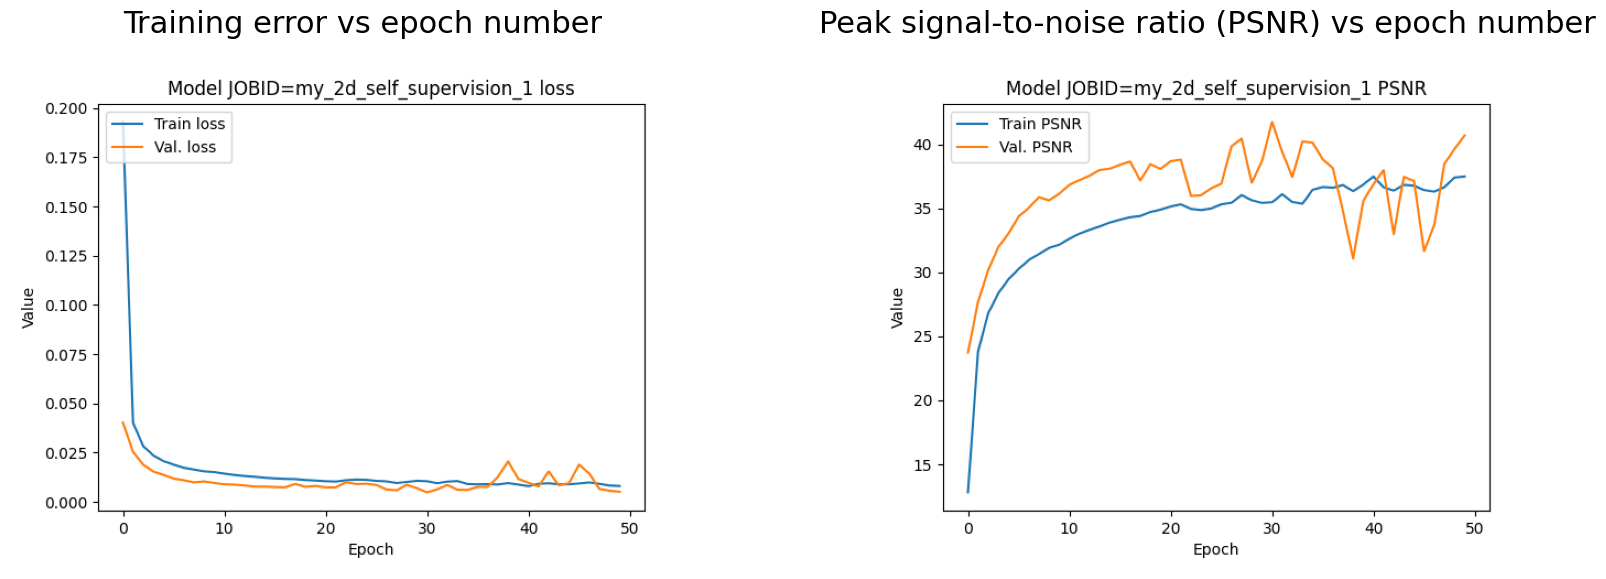

In [ ]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and PSNR vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

psnr_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_PSNR.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( psnr_plot )
_ = plt.axis('off')
_= ax2.set_title( 'Peak signal-to-noise ratio (PSNR) vs epoch number', fontdict = {'fontsize':22})

## **Visualize self-supervision reconstruction results**


In [ ]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")
ssl_results = os.path.join(final_results, "per_image")
gt_data_path = train_data_path+"_ssl_source"

#@markdown ###Play to visualize some results
from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(ssl_results))[2])
ids_input = sorted(next(os.walk(train_data_path))[2])
ids_gt = sorted(next(os.walk(gt_data_path))[2])

samples_to_show = min(len(ids_input), 2)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False)
seed(1)

test_samples = []
test_sample_preds = []
test_sample_gt  = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(gt_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)

    aux = imread(os.path.join(ssl_results, ids_pred[chosen_images[i]]))
    test_sample_preds.append(aux)

    aux = imread(os.path.join(train_data_path, ids_gt[chosen_images[i]]))
    test_sample_gt.append(aux)

# Show predicted images
plt.figure(figsize=(20,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 3, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='gray')
    index = index + 1

    plt.subplot(samples_to_show, 3, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap='gray', interpolation='nearest')
    index = index + 1

    plt.subplot(samples_to_show, 3, index)
    plt.title("Ground truth")
    plt.imshow(test_sample_gt[j], cmap='gray', interpolation='nearest')
    index = index + 1
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@markdown ###Play to display the paths to the output files (one 2D TIFF image for each input image).

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

if biapy_config['TEST']['STATS']['FULL_IMG'] == True:
    prob_results = os.path.join(final_results, "full_image")
else:
    prob_results = os.path.join(final_results, "per_image")
print("Output paths:")
print("    Self-supervision output files are in {}".format(prob_results))

Output paths:
    Self-supervision output files are in /content/output/my_2d_self_supervision/results/my_2d_self_supervision_1/per_image


## **Download  results**

In [ ]:
#@markdown ###Play to download a zip file with all self-supervision results in test.

from google.colab import files

!zip -q -j /content/self-supervision_results.zip $ssl_results/*.tif

files.download("/content/self-supervision_results.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
The main purpose of this workflow is to **reuse the trained model in the future** . For that reason, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [ ]:
#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = 'model_weights_' + str( job_name ) + '_1.h5'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Acknowledgments**
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters.